_This notebook contains code and comments from Section 6.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 6.2 Newton Boosting: Newton Descent + Boosting
Gradient boosting combines gradient descent and boosting. Instead of computing the overall true gradient explicitly, gradient boosting aims to **approximate the true gradient** with a weak learner. 

Let's begin by generating a simple two-dimensional to visualize how gradient descent works step-by-step.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from visualization import plot_2d_data
import numpy as np

---
#### The Logistic Loss
We look at the shapes of the logistic loss function as well as its first and second derivatives

In [2]:
%matplotlib inline
# The logistic loss
def log_loss_func(x):
    return np.log(1 + np.exp(-x))
    
# The gradient of the sigmoid function
def log_loss_grad(x):
    return -np.exp(-x) / (np.exp(-x) + 1)
    
# The Hessian of the sigmoid function    
def log_loss_hess(x):
    return np.exp(x) / (1 + np.exp(x))**2

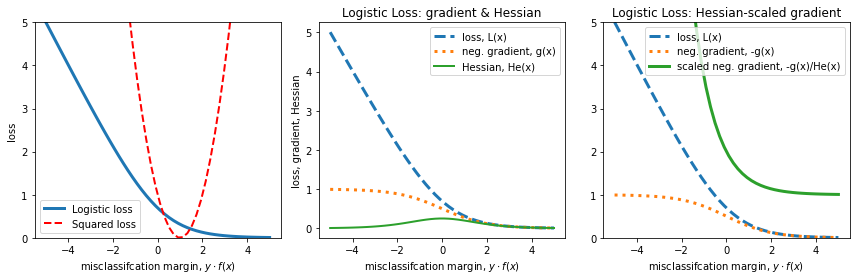

In [3]:
x = np.linspace(-2., 2., num=50)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

x = np.linspace(-5., 5., num=50)
ax[0].plot(x, log_loss_func(x), linewidth=3)
ax[0].plot(x, (1 - x)**2, linewidth=2, linestyle='--', c='r')
ax[0].set_ylim(0, 5)
ax[0].set_xlabel('misclassifcation margin, $y \cdot f(x) $')
ax[0].set_ylabel('loss')
ax[0].legend(['Logistic loss', 'Squared loss']);


ax[1].plot(x, log_loss_func(x), linewidth=3, linestyle='--')
ax[1].plot(x, -log_loss_grad(x), linewidth=3, linestyle=':')
ax[1].plot(x, log_loss_hess(x), linewidth=2)
ax[1].legend(['loss, L(x)', 'neg. gradient, g(x)', 'Hessian, He(x)'])
ax[1].set_xlabel('misclassifcation margin, $y \cdot f(x)$')
ax[1].set_ylabel('loss, gradient, Hessian')
ax[1].set_title('Logistic Loss: gradient & Hessian')

ax[2].plot(x, log_loss_func(x), linewidth=3, linestyle='--')
ax[2].plot(x, -log_loss_grad(x), linewidth=3, linestyle=':')
ax[2].plot(x, -log_loss_grad(x) / log_loss_hess(x), linewidth=3)
ax[2].set_xlabel('misclassifcation margin, $y \cdot f(x)$')
ax[2].legend(['loss, L(x)', 'neg. gradient, -g(x)', 'scaled neg. gradient, -g(x)/He(x)'])
ax[2].set_title('Logistic Loss: Hessian-scaled gradient')
ax[2].set_ylim(0, 5)

fig.tight_layout()
pngFile = './figures/CH06_F07_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight')

### 6.2.1 Intuition: Learning with weighted residuals


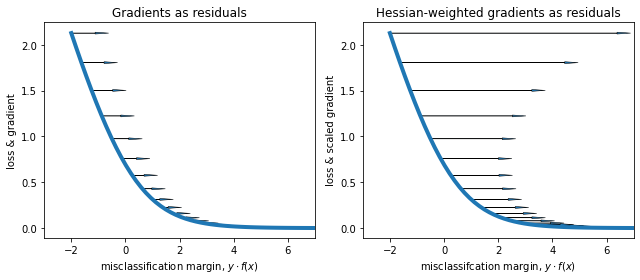

In [4]:
x = np.linspace(-2., 7., num=50)
z = np.linspace(-2., 4., num=17)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot gradients
ax[0].plot(x, log_loss_func(x), linewidth=4)
for u in z:
    ax[0].arrow(u, log_loss_func(u), -log_loss_grad(u), 0., linewidth=0.5, head_length=0.5, head_width=0.02)
ax[0].set_xlabel('misclassification margin, $y \cdot f(x)$')
ax[0].set_ylabel('loss & gradient')
ax[0].set_xlim([-3, 7])
ax[0].set_title('Gradients as residuals')

# Plot scaled gradients
ax[1].plot(x, log_loss_func(x), linewidth=4)
for u in z:
    ax[1].arrow(u, log_loss_func(u), -log_loss_grad(u)/log_loss_hess(u), 0., linewidth=0.5, head_length=0.5, head_width=0.02)
ax[1].set_xlabel('misclassifcation margin, $y \cdot f(x)$')
ax[1].set_ylabel('loss & scaled gradient')
ax[1].set_title('Hessian-weighted gradients as residuals')
ax[1].set_xlim([-3, 7])

fig.tight_layout()
pngFile = './figures/CH06_F08_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight')

Create a new data set to explore the loss functions and boosting

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.15, random_state=13)
y = 2 * y - 1

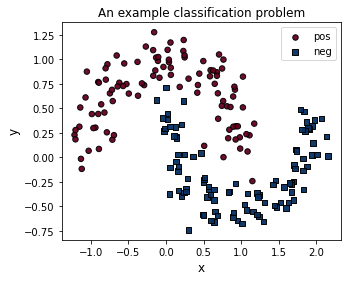

In [6]:
# %matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2d_data(ax, X, y, xlabel='x', ylabel='y', s=30,
             title='An example classification problem', 
             legend=['pos', 'neg'], colormap='RdBu')


# fig.tight_layout()
# pngFile = './figures/CH06_FXX_Kunapuli.png'
# plt.savefig(pngFile, dpi=300, bbox_inches='tight')

Visualize the unregularized and regularized loss function profiles

In [7]:
from sklearn.tree import DecisionTreeRegressor
from visualization import plot_2d_classifier, get_colors
from scipy.optimize import minimize_scalar
from sklearn.metrics import accuracy_score

# Set up a mesh for 3d plotting
xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05), 
                           np.arange(yMin, yMax, 0.05))

cm = get_colors(n_colors=2, colormap='RdBu')
views = [(30, 16), (48, -116), (11, 108)]

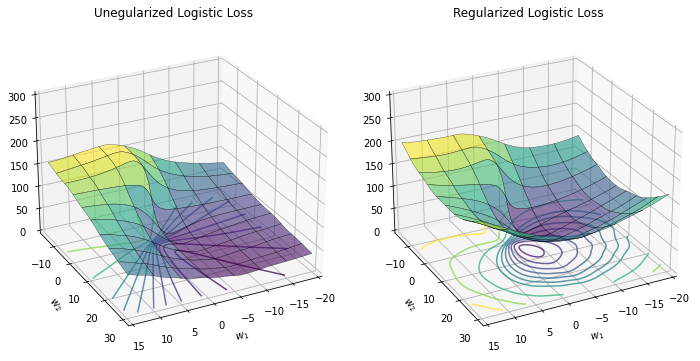

In [8]:
%matplotlib inline

def log_loss(w, X, y):
    return np.sum(1 / (1 + np.exp(-y * np.dot(X, w)))) + 0.1 * np.dot(w, w)

def unregularized_log_loss(w, X, y):
    return np.sum(1 / (1 + np.exp(-y * np.dot(X, w))))

# Set up plotting
fig = plt.figure(figsize=(10, 5))
w1Min, w1Max, w2Min, w2Max = -20, 15, -15, 30
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.25), np.arange(w2Min, w2Max, 0.25))

# Plot the unregularized loss
z = np.apply_along_axis(unregularized_log_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(w1, w2, z, rstride=20, cstride=20, alpha=0.6, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.contour(w1, w2, z, 
           levels=np.array([30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175]), cmap='viridis', alpha=0.75, offset=0)

ax.view_init(elev=26.0, azim=63.0)
ax.set_xlim(-20, 15)
ax.set_zlim(0, 300)
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_title('Unegularized Logistic Loss');

# Compute the regularized Loss function in this domain
z = np.apply_along_axis(log_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(w1, w2, z, rstride=20, cstride=20, alpha=0.6, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.contour(w1, w2, z, 
           levels=np.array([30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175]), cmap='viridis', alpha=0.75, offset=0)

ax.view_init(elev=26.0, azim=63.0)
ax.set_xlim(-20, 15)
ax.set_zlim(0, 300)
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_title('Regularized Logistic Loss');

fig.tight_layout()
pngFile = './figures/CH06_F09_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight')

**Listing 6.2**: Regularized logistic loss function, its gradient and Hessian

In [9]:
# Define the regularized logistic loss over true and predicted
def log_loss_func(y, F):
    return np.log(1 + np.exp(-y * F)) + 0.1 * F**2
    
# The gradient of the sigmoid function
def log_loss_grad(y, F):
    return -y / (1 + np.exp(y * F)) + 0.2 * F
    
# The Hessian of the sigmoid function    
def log_loss_hess(y, F):
    return np.exp(y * F) / (1 + np.exp(y * F))**2 + 0.2

<IPython.core.display.Javascript object>


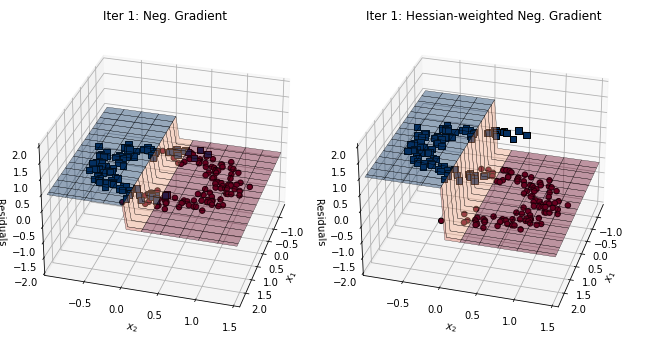

<IPython.core.display.Javascript object>


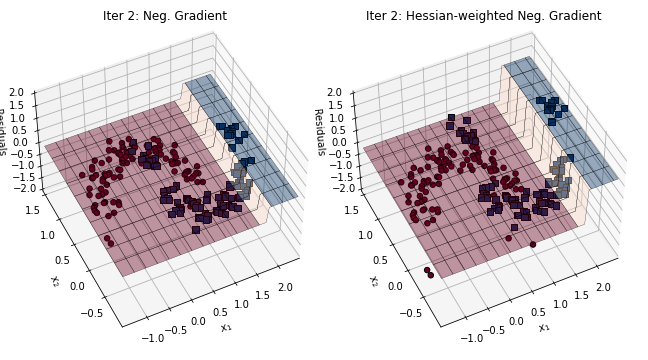

<IPython.core.display.Javascript object>


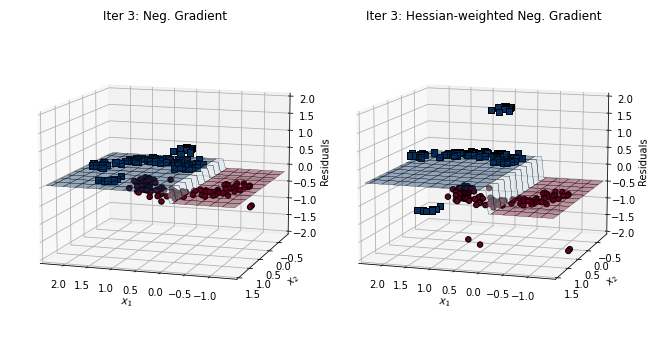

In [10]:
%matplotlib notebook

def sig(x):
    # Sigmoid function
    return 1 / (1 + np.exp(-x))

def h_as_classifier(x, h):
    # Logistic regression predicts x as positive if p(y = 1 | x) >= p(y = -1 | x)
    pred = h.predict(x)
    return 2 * (sig(pred) >= sig(-pred)).astype(int) - 1

def F_as_classifier(x, ens):
    # Logistic regression predicts x as positive if p(y = 1 | x) >= p(y = -1 | x)
    pred = np.sum([a * h.predict(x) for (a, h) in ensemble], axis=0)
    return 2 * (sig(pred) >= sig(-pred)).astype(int) - 1


# Initialize
n_samples, n_features = X.shape
n_estimators = 10
ensemble = []
F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble

for t in range(n_estimators):
    # Fit a weak learner to the Hessian-weighted residuals, which are computed as gradient(Loss(y, F))
    residuals = -log_loss_grad(y, F) / log_loss_hess(y, F)   
    h = DecisionTreeRegressor(max_depth=1)
    h.fit(X, residuals)
        
    # Fit a weak learner to the standard residuals
    residuals_grad_only = -log_loss_grad(y, F)
    h2 = DecisionTreeRegressor(max_depth=1)
    h2.fit(X, residuals_grad_only)
           
    # ----------------------------------------------    
    # Visualize the residuals and their fit in 3d
    if t in [0, 1, 2]:
        fig = plt.figure(figsize=(9, 5))

        ax = fig.add_subplot(1, 2, 1, projection='3d')
        zMesh = h2.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
        zMesh = zMesh.reshape(xMesh.shape)
        grad_surface = ax.plot_surface(xMesh, yMesh, zMesh, rstride=5, cstride=5, 
                        alpha=0.4, linewidth=0.25, edgecolors='k', cmap='RdBu')
        ax.view_init(elev=views[t][0], azim=views[t][1])
        ax.scatter(X[y<0, 0], X[y<0, 1], residuals_grad_only[y<0], c=cm[0], marker='o', s=30, alpha=1, edgecolors='k')
        ax.scatter(X[y>0, 0], X[y>0, 1], residuals_grad_only[y>0], c=cm[1], marker='s', s=40, alpha=1, edgecolors='k')
        ax.set_xlabel('$x_1$')
        ax.set_xlim(xMin, xMax)
        ax.set_ylabel('$x_2$')
        ax.set_ylim(yMin, yMax)
        ax.set_zlim(-2, 2)
        ax.set_zlabel('Residuals')
        ax.set_title('Iter {0}: Neg. Gradient'.format(t + 1))

        ax = fig.add_subplot(1, 2, 2, projection='3d')
        zMesh = h.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
        zMesh = zMesh.reshape(xMesh.shape)
        grad_surface = ax.plot_surface(xMesh, yMesh, zMesh, rstride=5, cstride=5, 
                        alpha=0.4, linewidth=0.25, edgecolors='k', cmap='RdBu')
        ax.view_init(elev=views[t][0], azim=views[t][1])
        ax.scatter(X[y<0, 0], X[y<0, 1], residuals[y<0], c=cm[0], marker='o', s=30, alpha=1, edgecolors='k')
        ax.scatter(X[y>0, 0], X[y>0, 1], residuals[y>0], c=cm[1], marker='s', s=40, alpha=1, edgecolors='k')
        ax.set_xlabel('$x_1$')
        ax.set_xlim(xMin, xMax)
        ax.set_ylabel('$x_2$')
        ax.set_ylim(yMin, yMax)
        ax.set_zlim(-2, 2)
        ax.set_zlabel('Residuals')
        ax.set_title('Iter {0}: Hessian-weighted Neg. Gradient'.format(t + 1))

        fig.tight_layout()
        pngFile = './figures/CH06_F{0:02d}_Kunapuli.png'.format(t + 10)
        plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)
    # ----------------------------------------------   

    # Compute a step length that produces the best improvement in the loss
    hreg = h.predict(X)
    a = 1.
      
    # Compute the error of the new classifier
    F += a * hreg
    
    # Update the ensemble
    ensemble.append((a, h))
    
    # ----------------------------------------------   
    hpred = h_as_classifier(X, h)
    herr = 1 - accuracy_score(y, hpred)
        
    Fpred = F_as_classifier(X, F)
    Ferr = 1 - accuracy_score(y, Fpred)
    
    # ----------------------------------------------   

---
### 6.3.2 Implementing Newton Boosting

As before, we will put our intuition to practice by implementing our own version of gradient boosting. The basic algorithm can be outlined with the following pseudocode:

``Initialize the ensemble: F=f_0``, some constant value

``for t = 1 to T:``
   1. compute the first and second derivatives $g_i^t=∂L/∂F(x_i)$, $He_i^t=∂^2L/∂F(x_i)^2$ 
   2. compute the weighted residuals for each example, $r_i^t=-g_i^t / h_i^t$ 
   2. fit a weak decision tree regressor $h_t (x)$ using the training set $(x_i,r_i )_(i=1)^n$
   3. compute the step length ($\alpha_t$) using line search 
   4. update the model: $F = F + \alpha_t⋅ h_t (x)$
   
**Listing 6.3**: Newton Boosting for the regularized logistic loss

In [11]:
def fit_gradient_boosting(X, y, n_estimators=10, use_newton=True):
     # Initialize
    n_samples, n_features = X.shape
    estimators = []
    F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble
    
    for t in range(n_estimators):
        # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
        if use_newton:
            residuals = -log_loss_grad(y, F) / log_loss_hess(y, F)
        else:
            residuals = -log_loss_grad(y, F)
            
        h = DecisionTreeRegressor(max_depth=1)
        h.fit(X, residuals)
    
        # Compute a step length that produces the best improvement in the loss
        hreg = h.predict(X)
        loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
        step = minimize_scalar(loss, method='golden')
        a = step.x
        
        # Update the ensemble predictions
        F += a * hreg
        
        # Update the ensemble
        estimators.append((a, h))
    
    return estimators

Once the model is learned, we can make predictions exactly as with gradient boosting. Note that, just like our AdaBoost and gradient boosting implementations previously, this model returns predictions of -1/1 rather than 0/1.

**Listing 6.4**: Predictions of Newton boosting

In [12]:
def predict_gradient_boosting(X, estimators):
    pred = np.zeros((X.shape[0], ))

    for a, h in estimators:
        pred += a * h.predict(X)

    y = np.sign(pred)

    return y

In [13]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25, random_state=11)

estimators_nb = fit_gradient_boosting(Xtrn, ytrn, n_estimators=25, use_newton=True)
ypred_nb = predict_gradient_boosting(Xtst, estimators_nb)
print('Newton boosting test error = {0}'.format(1 - accuracy_score(ypred_nb, ytst)))

estimators_gb = fit_gradient_boosting(Xtrn, ytrn, n_estimators=25, use_newton=False)
ypred_gb = predict_gradient_boosting(Xtst, estimators_gb)
print('Gradient boosting test error = {0}'.format(1 - accuracy_score(ypred_gb, ytst)))

Newton boosting test error = 0.07999999999999996
Gradient boosting test error = 0.12


Finally, we visualize the performance of Newton boosting as the number of base estimators increases in the figure below. As we add more and more weak learners into the mix, the overall ensemble is increasingly boosted into a stronger, more complex and more nonlinear classifier.

<IPython.core.display.Javascript object>


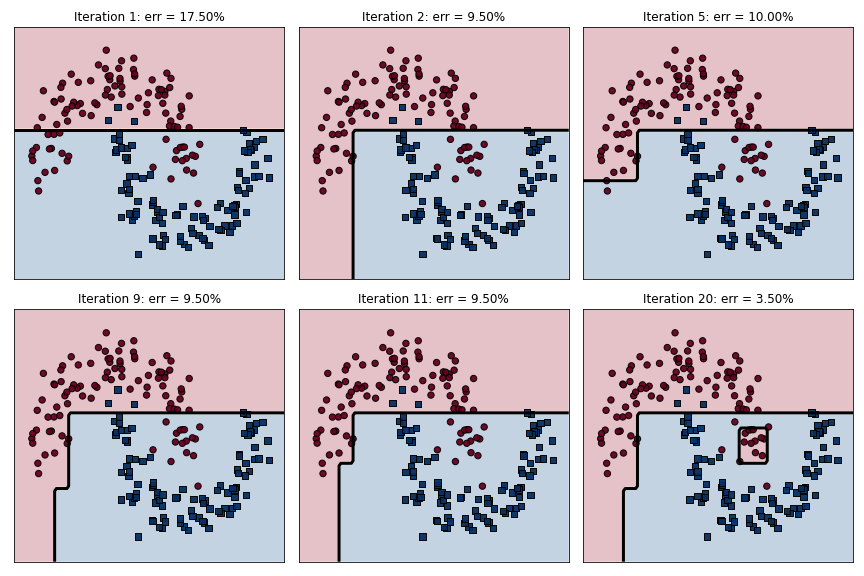

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
subplot_id = -1
for t in [0, 1, 4, 8, 10, 19]:
    subplot_id += 1
    r, c = np.divmod(subplot_id, 3)
    err = (1 - accuracy_score(y, predict_gradient_boosting(X, estimators_nb[:t+1]))) * 100

    title = 'Iteration {0}: err = {1:4.2f}%'.format(t + 1, err)
    plot_2d_classifier(ax[r, c], X, y, 
                       predict_function=predict_gradient_boosting, predict_args=estimators_nb[:t+1],
                       alpha=0.25, xlabel=None, ylabel=None, boundary_level=[0.0],
                       title=title, colormap='RdBu', s=40)
    ax[r, c].set_xticks([])
    ax[r, c].set_yticks([])

fig.tight_layout()
pngFile = './figures/CH06_F13_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)